# Running correlations between gene expression and OTU abundance


## Filtering lowly expressed genes and lowly abundant OTUs

 * Remove genes with less than one mapped read per million reads in at least 80% of samples ([Johnson and Krishnan, 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02568-9))
 * Retaining OTUs found at 0.001 relative abundance in at least 10% of the samples ([Priya et al 2022](https://www.nature.com/articles/s41564-022-01121-z))

### Filtering genes

Since RPKM will be used to filter out genes with low expression, it must be imported first:

In [23]:
import pandas as pd

kremling_expression_v5_day_rpkm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm.tsv',
#kremling_expression_v5_day_rpkm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm.tsv',
                            sep='\t')
kremling_expression_v5_day_rpkm.set_index('Name', inplace=True)

kremling_expression_v5_night_rpkm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm.tsv',
#kremling_expression_v5_night_rpkm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm.tsv',
                            sep='\t')
kremling_expression_v5_night_rpkm.set_index('Name', inplace=True)

In [24]:
print(kremling_expression_v5_day_rpkm.shape)
print(kremling_expression_v5_night_rpkm.shape)

(39096, 176)
(39096, 228)


These are the genes to be used in filtering steps:

Warning: SparXCC, one of the methods being tested to correlate genes and OTUs, does not provide good estimates with low counts and also does not scale up well in terms of running time and memory (see: [CompoCor repository, issue #1](https://github.com/IbTJensen/CompoCor/issues/1)). Thefore, for this particular software I increased the RPKM filter (from 1 to 3)

In [25]:
#genes_tokeep_day = kremling_expression_v5_day_rpkm[(kremling_expression_v5_day_rpkm > 3).sum(axis=1) >= (kremling_expression_v5_day_rpkm.shape[1] * 0.8)].index
#genes_tokeep_night = kremling_expression_v5_night_rpkm[(kremling_expression_v5_night_rpkm > 3).sum(axis=1) >= (kremling_expression_v5_night_rpkm.shape[1] * 0.8)].index
genes_tokeep_day = kremling_expression_v5_day_rpkm[(kremling_expression_v5_day_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_day_rpkm.shape[1] * 0.8)].index
genes_tokeep_night = kremling_expression_v5_night_rpkm[(kremling_expression_v5_night_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_night_rpkm.shape[1] * 0.8)].index
print('Genes to keep in day:', len(genes_tokeep_day))
print('Genes to keep in night:', len(genes_tokeep_night))

Genes to keep in day: 9567
Genes to keep in night: 10076


Filtering RPKM:

In [3]:
kremling_expression_v5_day_rpkm_filtered = kremling_expression_v5_day_rpkm[(kremling_expression_v5_day_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_day_rpkm.shape[1] * 0.8)]
kremling_expression_v5_night_rpkm_filtered = kremling_expression_v5_night_rpkm[(kremling_expression_v5_night_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_night_rpkm.shape[1] * 0.8)]

Importing the counts matrices. Warming: filtered raw counts will be used in cases that methods reallly require raw counts!!
However, future investigation must be done to make sure this is not problematic.

In [26]:
kremling_expression_v5_day_counts = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/kremling_expression_v5_day.tsv',
                            sep='\t')
kremling_expression_v5_day_counts.set_index('Name', inplace=True)

kremling_expression_v5_night_counts = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/kremling_expression_v5_night.tsv',
                            sep='\t')
kremling_expression_v5_night_counts.set_index('Name', inplace=True)
print(kremling_expression_v5_day_counts.shape)
print(kremling_expression_v5_night_counts.shape)

(39096, 176)
(39096, 228)


Filtering the counts matrix based on RPKM values:

In [27]:
kremling_expression_v5_day_counts_filtered = kremling_expression_v5_day_counts[kremling_expression_v5_day_counts.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_counts_filtered = kremling_expression_v5_night_counts[kremling_expression_v5_night_counts.index.isin(genes_tokeep_night)]
print(kremling_expression_v5_day_counts_filtered.shape)
print(kremling_expression_v5_night_counts_filtered.shape)

(9567, 176)
(10076, 228)


Importing the TPM, CPM, TMM, UQ, CTF and CUF matrices and filter genes:

In [4]:
#kremling_expression_v5_day_tpm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm.tsv',
kremling_expression_v5_day_tpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm.tsv',
                            sep='\t')
kremling_expression_v5_day_tpm.set_index('Name', inplace=True)

kremling_expression_v5_night_tpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm.tsv',
#kremling_expression_v5_night_tpm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm.tsv',
                            sep='\t')
kremling_expression_v5_night_tpm.set_index('Name', inplace=True)

kremling_expression_v5_day_tpm_filtered = kremling_expression_v5_day_tpm[kremling_expression_v5_day_tpm.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_tpm_filtered = kremling_expression_v5_night_tpm[kremling_expression_v5_night_tpm.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm.tsv',
#kremling_expression_v5_day_cpm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm.tsv',
                            sep='\t')
kremling_expression_v5_day_cpm.set_index('Name', inplace=True)

kremling_expression_v5_night_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm.tsv',
#kremling_expression_v5_night_cpm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm.tsv',
                            sep='\t')
kremling_expression_v5_night_cpm.set_index('Name', inplace=True)

kremling_expression_v5_day_cpm_filtered = kremling_expression_v5_day_cpm[kremling_expression_v5_day_cpm.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_cpm_filtered = kremling_expression_v5_night_cpm[kremling_expression_v5_night_cpm.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_tmm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm.tsv',
#kremling_expression_v5_day_tmm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm.tsv',
                            sep='\t')
kremling_expression_v5_day_tmm.set_index('Name', inplace=True)

kremling_expression_v5_night_tmm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm.tsv',
#kremling_expression_v5_night_tmm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm.tsv',
                            sep='\t')
kremling_expression_v5_night_tmm.set_index('Name', inplace=True)

kremling_expression_v5_day_tmm_filtered = kremling_expression_v5_day_tmm[kremling_expression_v5_day_tmm.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_tmm_filtered = kremling_expression_v5_night_tmm[kremling_expression_v5_night_tmm.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_uq = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq.tsv',
#kremling_expression_v5_day_uq = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq.tsv',
                            sep='\t')
kremling_expression_v5_day_uq.set_index('Name', inplace=True)

kremling_expression_v5_night_uq = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq.tsv',
#kremling_expression_v5_night_uq = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq.tsv',
                            sep='\t')
kremling_expression_v5_night_uq.set_index('Name', inplace=True)

kremling_expression_v5_day_uq_filtered = kremling_expression_v5_day_uq[kremling_expression_v5_day_uq.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_uq_filtered = kremling_expression_v5_night_uq[kremling_expression_v5_night_uq.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_ctf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf.tsv',
#kremling_expression_v5_day_ctf = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf.tsv',
                            sep='\t')
kremling_expression_v5_day_ctf.set_index('Name', inplace=True)

kremling_expression_v5_night_ctf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf.tsv',
#kremling_expression_v5_night_ctf = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf.tsv',
                            sep='\t')
kremling_expression_v5_night_ctf.set_index('Name', inplace=True)

kremling_expression_v5_day_ctf_filtered = kremling_expression_v5_day_ctf[kremling_expression_v5_day_ctf.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_ctf_filtered = kremling_expression_v5_night_ctf[kremling_expression_v5_night_ctf.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_cuf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf.tsv',
#kremling_expression_v5_day_cuf = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf.tsv',
                            sep='\t')
kremling_expression_v5_day_cuf.set_index('Name', inplace=True)

kremling_expression_v5_night_cuf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf.tsv',
#kremling_expression_v5_night_cuf = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf.tsv',
                            sep='\t')
kremling_expression_v5_night_cuf.set_index('Name', inplace=True)

kremling_expression_v5_day_cuf_filtered = kremling_expression_v5_day_cuf[kremling_expression_v5_day_cuf.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_cuf_filtered = kremling_expression_v5_night_cuf[kremling_expression_v5_night_cuf.index.isin(genes_tokeep_night)]

### Filtering OTUs

Since relative abundance will be used to filter out genes with low expression, it must be imported first:

In [31]:
import pandas as pd

otu_table_merged_day_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_day_relative_abund.tsv',
#otu_table_merged_day_relative_abund = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_day_relative_abund.tsv',
                            sep='\t')
otu_table_merged_day_relative_abund.set_index('OTU ID', inplace=True)

#otu_table_merged_night_relative_abund = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_night_relative_abund.tsv',
otu_table_merged_night_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_night_relative_abund.tsv',
                            sep='\t')
otu_table_merged_night_relative_abund.set_index('OTU ID', inplace=True)

In [32]:
print(otu_table_merged_day_relative_abund.shape)
print(otu_table_merged_night_relative_abund.shape)

(9057, 176)
(9057, 228)


In [33]:
otus_tokeep_day = otu_table_merged_day_relative_abund[(otu_table_merged_day_relative_abund > 0.001).sum(axis=1) >= (otu_table_merged_day_relative_abund.shape[1] * 0.1)].index
otus_tokeep_night = otu_table_merged_night_relative_abund[(otu_table_merged_night_relative_abund > 0.001).sum(axis=1) >= (otu_table_merged_night_relative_abund.shape[1] * 0.1)].index

OTU matrices with relative abundances are filtered (based on relative abundance) for correlations:

In [7]:
otu_table_merged_day_relative_abund_filtered = otu_table_merged_day_relative_abund[otu_table_merged_day_relative_abund.index.isin(otus_tokeep_day)]
otu_table_merged_night_relative_abund_filtered = otu_table_merged_night_relative_abund[otu_table_merged_night_relative_abund.index.isin(otus_tokeep_night)]

In [8]:
print(otu_table_merged_day_relative_abund_filtered.shape)
print(otu_table_merged_night_relative_abund_filtered.shape)

(3681, 176)
(3712, 228)


Exporting matrices to files:

In [ ]:
#otu_table_merged_day_relative_abund_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_relative_abund_filtered.tsv',
otu_table_merged_day_relative_abund_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_relative_abund_filtered.tsv',
                            sep='\t')
#otu_table_merged_night_relative_abund_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_relative_abund_filtered.tsv',
otu_table_merged_night_relative_abund_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_relative_abund_filtered.tsv',
                            sep='\t')

Importing the OTU CPM matrices and filter OTUs:

In [9]:
otu_table_merged_day_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_day_cpm.tsv',
#otu_table_merged_day_cpm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_day_cpm.tsv',
                            sep='\t')
otu_table_merged_day_cpm.set_index('OTU ID', inplace=True)

otu_table_merged_night_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_night_cpm.tsv',
#otu_table_merged_night_cpm = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_night_cpm.tsv',
                            sep='\t')
otu_table_merged_night_cpm.set_index('OTU ID', inplace=True)

OTU matrices are filtered based on relative abundance:

In [10]:
otu_table_merged_day_cpm_filtered = otu_table_merged_day_cpm[otu_table_merged_day_cpm.index.isin(otus_tokeep_day)]
otu_table_merged_night_cpm_filtered = otu_table_merged_night_cpm[otu_table_merged_night_cpm.index.isin(otus_tokeep_night)]

In [11]:
print(otu_table_merged_day_cpm_filtered.shape)
print(otu_table_merged_night_cpm_filtered.shape)

(3681, 176)
(3712, 228)


Importing the OTU counts matrices and filter OTUs:

In [ ]:
#otu_table_merged_counts = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
otu_table_merged_counts = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
                            sep='\t')
otu_table_merged_counts.set_index('OTU ID', inplace=True)

OTU matrices are filtered based on day and night samples:

In [ ]:
otu_table_merged_counts_day = otu_table_merged_counts[otu_table_merged_day_cpm_filtered.columns]
otu_table_merged_counts_night = otu_table_merged_counts[otu_table_merged_night_cpm_filtered.columns]

OTU counts matrices are filtered based on relative abundance:

In [ ]:
otu_table_merged_counts_day_filtered = otu_table_merged_counts_day[otu_table_merged_counts_day.index.isin(otus_tokeep_day)]
otu_table_merged_counts_night_filtered = otu_table_merged_counts_night[otu_table_merged_counts_night.index.isin(otus_tokeep_night)]

In [ ]:
print(otu_table_merged_counts_day_filtered.shape)
print(otu_table_merged_counts_night_filtered.shape)

Exporting filtered count tables for day and night:

In [ ]:
#otu_table_merged_counts_day_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_day_filtered.tsv',
otu_table_merged_counts_day_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_day_filtered.tsv',
                            sep='\t')
#otu_table_merged_counts_night_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_night_filtered.tsv',
otu_table_merged_counts_night_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_night_filtered.tsv',
                            sep='\t')

Importing matrices: (alternative to generation)

In [34]:
otu_table_merged_counts_day_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_day_filtered.tsv',
                            sep='\t')
otu_table_merged_counts_day_filtered.set_index('OTU ID', inplace=True)

otu_table_merged_counts_night_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_night_filtered.tsv',
                            sep='\t')
otu_table_merged_counts_night_filtered.set_index('OTU ID', inplace=True)
print(otu_table_merged_counts_day_filtered.shape)
print(otu_table_merged_counts_night_filtered.shape)

(3681, 176)
(3712, 228)


### Filtering OTU data collapsed to genus and family levels

Since relative abundance will be used to filter out genes with low expression, it must be imported first.
Relative abundance matrices were calculated after collapsing OTU data at genus and family levels.

In [2]:
import pandas as pd

# Genus level - relative abundance
genus_table_merged_day_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_day_relative_abund.tsv',
                            sep='\t')
genus_table_merged_day_relative_abund.set_index('Genus', inplace=True)

genus_table_merged_night_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_night_relative_abund.tsv',
                            sep='\t')
genus_table_merged_night_relative_abund.set_index('Genus', inplace=True)

# Family level - relative abundance
family_table_merged_day_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_day_relative_abund.tsv',
                            sep='\t')
family_table_merged_day_relative_abund.set_index('Family', inplace=True)

family_table_merged_night_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_night_relative_abund.tsv',
                            sep='\t')
family_table_merged_night_relative_abund.set_index('Family', inplace=True)

Filtering genus and family based on relative abundance:

In [3]:
genus_tokeep_day = genus_table_merged_day_relative_abund[(genus_table_merged_day_relative_abund > 0.001).sum(axis=1) >= (genus_table_merged_day_relative_abund.shape[1] * 0.1)].index
genus_tokeep_night = genus_table_merged_night_relative_abund[(genus_table_merged_night_relative_abund > 0.001).sum(axis=1) >= (genus_table_merged_night_relative_abund.shape[1] * 0.1)].index
family_tokeep_day = family_table_merged_day_relative_abund[(family_table_merged_day_relative_abund > 0.001).sum(axis=1) >= (family_table_merged_day_relative_abund.shape[1] * 0.1)].index
family_tokeep_night = family_table_merged_night_relative_abund[(family_table_merged_night_relative_abund > 0.001).sum(axis=1) >= (family_table_merged_night_relative_abund.shape[1] * 0.1)].index

Importing CPM data at genus and family levels:

In [9]:
genus_table_merged_d_n_day_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_day_cpm.tsv',
                            sep='\t')
genus_table_merged_d_n_day_cpm.set_index('Genus', inplace=True)
genus_table_merged_d_n_night_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_night_cpm.tsv',
                            sep='\t')
genus_table_merged_d_n_night_cpm.set_index('Genus', inplace=True)
family_table_merged_d_n_day_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_day_cpm.tsv',
                            sep='\t')
family_table_merged_d_n_day_cpm.set_index('Family', inplace=True)
family_table_merged_d_n_night_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_night_cpm.tsv',
                            sep='\t')
family_table_merged_d_n_night_cpm.set_index('Family', inplace=True)

In [10]:
genus_table_merged_d_n_day_cpm_filtered = genus_table_merged_d_n_day_cpm[genus_table_merged_d_n_day_cpm.index.isin(genus_tokeep_day)]
genus_table_merged_d_n_night_cpm_filtered = genus_table_merged_d_n_night_cpm[genus_table_merged_d_n_night_cpm.index.isin(genus_tokeep_night)]
family_table_merged_d_n_day_cpm_filtered = family_table_merged_d_n_day_cpm[family_table_merged_d_n_day_cpm.index.isin(family_tokeep_day)]
family_table_merged_d_n_night_cpm_filtered = family_table_merged_d_n_night_cpm[family_table_merged_d_n_night_cpm.index.isin(family_tokeep_night)]

In [12]:
print(genus_table_merged_d_n_day_cpm_filtered.shape)
print(genus_table_merged_d_n_night_cpm_filtered.shape)
print(family_table_merged_d_n_day_cpm_filtered.shape)
print(family_table_merged_d_n_night_cpm_filtered.shape)

(204, 176)
(207, 228)
(107, 176)
(114, 228)


## Filtering low variance (expression, OTUs, or taxonomy collapsed at genus or family)


[Priya et al 2022](https://www.nature.com/articles/s41564-022-01121-z) used 25% quantile as cutoff for gene expression analysis.

Warning: In the case of gene counts, filtering expression was changed from minimum of 3 (instead of 1). Gene/transcript counts was used to run SparXCC, one of the methods being tested to correlate OTUs and gene expression.

In [28]:
import numpy as np

# Calculate the coefficient of variation for each row
kremling_expression_v5_day_counts_filtered_cv = kremling_expression_v5_day_counts_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_counts_filtered_cv = kremling_expression_v5_night_counts_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_counts_filtered_cv_filtered = kremling_expression_v5_night_counts_filtered.loc[kremling_expression_v5_night_counts_filtered_cv[kremling_expression_v5_night_counts_filtered_cv > kremling_expression_v5_night_counts_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_counts_filtered_cv_filtered = kremling_expression_v5_day_counts_filtered.loc[kremling_expression_v5_day_counts_filtered_cv[kremling_expression_v5_day_counts_filtered_cv > kremling_expression_v5_day_counts_filtered_cv.quantile(q=0.25)].index]
print(kremling_expression_v5_day_counts_filtered_cv_filtered.shape)
print(kremling_expression_v5_night_counts_filtered_cv_filtered.shape)

(7175, 176)
(7557, 228)


## Exporting expression COUNTS matrices after filtering

Warning again: for the case of gene counts, RPKM-based filtering was changed (from 1 to 3), in order to reduce the frequence of low counts genes, which reduces the realibility of SparXCC, a methods being tested to correlate genes and OTUs.


In [30]:
kremling_expression_v5_day_counts_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_counts_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_counts_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_counts_filtered_cv_filtered.tsv',
                            sep='\t')

Filtering the Gene CPM, TPM, RPKM, TMM, UQ, CTF and CUF matrices:

In [ ]:
import numpy as np

# Calculate the coefficient of variation for each row
kremling_expression_v5_day_tpm_filtered_cv = kremling_expression_v5_day_tpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tpm_filtered_cv = kremling_expression_v5_night_tpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tpm_filtered_cv_filtered = kremling_expression_v5_night_tpm_filtered.loc[kremling_expression_v5_night_tpm_filtered_cv[kremling_expression_v5_night_tpm_filtered_cv > kremling_expression_v5_night_tpm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_tpm_filtered_cv_filtered = kremling_expression_v5_day_tpm_filtered.loc[kremling_expression_v5_day_tpm_filtered_cv[kremling_expression_v5_day_tpm_filtered_cv > kremling_expression_v5_day_tpm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_cpm_filtered_cv = kremling_expression_v5_day_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cpm_filtered_cv = kremling_expression_v5_night_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cpm_filtered_cv_filtered = kremling_expression_v5_night_cpm_filtered.loc[kremling_expression_v5_night_cpm_filtered_cv[kremling_expression_v5_night_cpm_filtered_cv > kremling_expression_v5_night_cpm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_cpm_filtered_cv_filtered = kremling_expression_v5_day_cpm_filtered.loc[kremling_expression_v5_day_cpm_filtered_cv[kremling_expression_v5_day_cpm_filtered_cv > kremling_expression_v5_day_cpm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_rpkm_filtered_cv = kremling_expression_v5_day_rpkm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_rpkm_filtered_cv = kremling_expression_v5_night_rpkm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_rpkm_filtered_cv_filtered = kremling_expression_v5_night_rpkm_filtered.loc[kremling_expression_v5_night_rpkm_filtered_cv[kremling_expression_v5_night_rpkm_filtered_cv > kremling_expression_v5_night_rpkm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_rpkm_filtered_cv_filtered = kremling_expression_v5_day_rpkm_filtered.loc[kremling_expression_v5_day_rpkm_filtered_cv[kremling_expression_v5_day_rpkm_filtered_cv > kremling_expression_v5_day_rpkm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_tmm_filtered_cv = kremling_expression_v5_day_tmm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tmm_filtered_cv = kremling_expression_v5_night_tmm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tmm_filtered_cv_filtered = kremling_expression_v5_night_tmm_filtered.loc[kremling_expression_v5_night_tmm_filtered_cv[kremling_expression_v5_night_tmm_filtered_cv > kremling_expression_v5_night_tmm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_tmm_filtered_cv_filtered = kremling_expression_v5_day_tmm_filtered.loc[kremling_expression_v5_day_tmm_filtered_cv[kremling_expression_v5_day_tmm_filtered_cv > kremling_expression_v5_day_tmm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_uq_filtered_cv = kremling_expression_v5_day_uq_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_uq_filtered_cv = kremling_expression_v5_night_uq_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_uq_filtered_cv_filtered = kremling_expression_v5_night_uq_filtered.loc[kremling_expression_v5_night_uq_filtered_cv[kremling_expression_v5_night_uq_filtered_cv > kremling_expression_v5_night_uq_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_uq_filtered_cv_filtered = kremling_expression_v5_day_uq_filtered.loc[kremling_expression_v5_day_uq_filtered_cv[kremling_expression_v5_day_uq_filtered_cv > kremling_expression_v5_day_uq_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_ctf_filtered_cv = kremling_expression_v5_day_ctf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_ctf_filtered_cv = kremling_expression_v5_night_ctf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_ctf_filtered_cv_filtered = kremling_expression_v5_night_ctf_filtered.loc[kremling_expression_v5_night_ctf_filtered_cv[kremling_expression_v5_night_ctf_filtered_cv > kremling_expression_v5_night_ctf_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_ctf_filtered_cv_filtered = kremling_expression_v5_day_ctf_filtered.loc[kremling_expression_v5_day_ctf_filtered_cv[kremling_expression_v5_day_ctf_filtered_cv > kremling_expression_v5_day_ctf_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_cuf_filtered_cv = kremling_expression_v5_day_cuf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cuf_filtered_cv = kremling_expression_v5_night_cuf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cuf_filtered_cv_filtered = kremling_expression_v5_night_cuf_filtered.loc[kremling_expression_v5_night_cuf_filtered_cv[kremling_expression_v5_night_cuf_filtered_cv > kremling_expression_v5_night_cuf_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_cuf_filtered_cv_filtered = kremling_expression_v5_day_cuf_filtered.loc[kremling_expression_v5_day_cuf_filtered_cv[kremling_expression_v5_day_cuf_filtered_cv > kremling_expression_v5_day_cuf_filtered_cv.quantile(q=0.25)].index]

In [ ]:
print(kremling_expression_v5_night_tpm_filtered_cv_filtered.shape)
print(kremling_expression_v5_day_tpm_filtered_cv_filtered.shape)

(10222, 228)
(9830, 176)


Filtering the OTU CPM matrices:

In [ ]:
import numpy as np

# Calculate the coefficient of variation for each row
otu_table_merged_day_cpm_filtered_cv = otu_table_merged_day_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_night_cpm_filtered_cv = otu_table_merged_night_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_day_cpm_filtered_cv_filtered = otu_table_merged_day_cpm_filtered.loc[otu_table_merged_day_cpm_filtered_cv[otu_table_merged_day_cpm_filtered_cv > otu_table_merged_day_cpm_filtered_cv.quantile(q=0.25)].index]
otu_table_merged_night_cpm_filtered_cv_filtered = otu_table_merged_night_cpm_filtered.loc[otu_table_merged_night_cpm_filtered_cv[otu_table_merged_night_cpm_filtered_cv > otu_table_merged_night_cpm_filtered_cv.quantile(q=0.25)].index]

In [ ]:
print(otu_table_merged_day_cpm_filtered_cv_filtered.shape)
print(otu_table_merged_night_cpm_filtered_cv_filtered.shape)

(2760, 176)
(2784, 228)


Filtering the OTU relative abundance matrices:

In [ ]:
# Calculate the coefficient of variation for each row
otu_table_merged_day_relative_abund_filtered_cv = otu_table_merged_day_relative_abund_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_night_relative_abund_filtered_cv = otu_table_merged_night_relative_abund_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_day_relative_abund_filtered_cv_filtered = otu_table_merged_day_relative_abund_filtered.loc[otu_table_merged_day_relative_abund_filtered_cv[otu_table_merged_day_relative_abund_filtered_cv > otu_table_merged_day_relative_abund_filtered_cv.quantile(q=0.25)].index]
otu_table_merged_night_relative_abund_filtered_cv_filtered = otu_table_merged_night_relative_abund_filtered.loc[otu_table_merged_night_relative_abund_filtered_cv[otu_table_merged_night_relative_abund_filtered_cv > otu_table_merged_night_relative_abund_filtered_cv.quantile(q=0.25)].index]

In [ ]:
print(otu_table_merged_day_relative_abund_filtered_cv_filtered.shape)
print(otu_table_merged_night_relative_abund_filtered_cv_filtered.shape)

(2760, 176)
(2784, 228)


Filtering the OTU counts matrices:

In [36]:
# Calculate the coefficient of variation for each row

otu_table_merged_counts_day_filtered_cv = otu_table_merged_counts_day_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_counts_night_filtered_cv = otu_table_merged_counts_night_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_counts_day_filtered_cv_filtered = otu_table_merged_counts_day_filtered.loc[otu_table_merged_counts_day_filtered_cv[otu_table_merged_counts_day_filtered_cv > otu_table_merged_counts_day_filtered_cv.quantile(q=0.25)].index]
otu_table_merged_counts_night_filtered_cv_filtered = otu_table_merged_counts_night_filtered.loc[otu_table_merged_counts_night_filtered_cv[otu_table_merged_counts_night_filtered_cv > otu_table_merged_counts_night_filtered_cv.quantile(q=0.25)].index]

print(otu_table_merged_counts_day_filtered_cv_filtered.shape)
print(otu_table_merged_counts_night_filtered_cv_filtered.shape)

(2760, 176)
(2784, 228)


Filtering the CPM matrices at genus or family levels:

In [ ]:
import numpy as np

# Calculate the coefficient of variation for each row
genus_table_merged_d_n_day_cpm_filtered_cv = genus_table_merged_d_n_day_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
genus_table_merged_d_n_night_cpm_filtered_cv = genus_table_merged_d_n_night_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
genus_table_merged_d_n_day_cpm_filtered_cv_filtered = genus_table_merged_d_n_day_cpm_filtered.loc[genus_table_merged_d_n_day_cpm_filtered_cv[genus_table_merged_d_n_day_cpm_filtered_cv > genus_table_merged_d_n_day_cpm_filtered_cv.quantile(q=0.25)].index]
genus_table_merged_d_n_night_cpm_filtered_cv_filtered = genus_table_merged_d_n_night_cpm_filtered.loc[genus_table_merged_d_n_night_cpm_filtered_cv[genus_table_merged_d_n_night_cpm_filtered_cv > genus_table_merged_d_n_night_cpm_filtered_cv.quantile(q=0.25)].index]

family_table_merged_d_n_day_cpm_filtered_cv = family_table_merged_d_n_day_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
family_table_merged_d_n_night_cpm_filtered_cv = family_table_merged_d_n_night_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
family_table_merged_d_n_day_cpm_filtered_cv_filtered = family_table_merged_d_n_day_cpm_filtered.loc[family_table_merged_d_n_day_cpm_filtered_cv[family_table_merged_d_n_day_cpm_filtered_cv > family_table_merged_d_n_day_cpm_filtered_cv.quantile(q=0.25)].index]
family_table_merged_d_n_night_cpm_filtered_cv_filtered = family_table_merged_d_n_night_cpm_filtered.loc[family_table_merged_d_n_night_cpm_filtered_cv[family_table_merged_d_n_night_cpm_filtered_cv > family_table_merged_d_n_night_cpm_filtered_cv.quantile(q=0.25)].index]

In [ ]:
print(genus_table_merged_d_n_day_cpm_filtered_cv_filtered.shape)
print(genus_table_merged_d_n_night_cpm_filtered_cv_filtered.shape)
print(family_table_merged_d_n_day_cpm_filtered_cv_filtered.shape)
print(family_table_merged_d_n_night_cpm_filtered_cv_filtered.shape)

(153, 176)
(155, 228)
(80, 176)
(85, 228)


## Exporting all matrices after filtering

Matrices with all OTU and gene expression data, after filtering out low expressed/abundant and low variance were exported to be transformed using R libraries. Exporting:

In [ ]:
# Exporting within sample normalized data after filtering
#kremling_expression_v5_day_tpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm_filtered_cv_filtered.tsv',
kremling_expression_v5_day_tpm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_tpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm_filtered_cv_filtered.tsv',
kremling_expression_v5_night_tpm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_day_rpkm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm_filtered_cv_filtered.tsv',
kremling_expression_v5_day_rpkm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_rpkm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm_filtered_cv_filtered.tsv',
kremling_expression_v5_night_rpkm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_day_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm_filtered_cv_filtered.tsv',
kremling_expression_v5_day_cpm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm_filtered_cv_filtered.tsv',
kremling_expression_v5_night_cpm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm_filtered_cv_filtered.tsv',
                            sep='\t')

# Exporting between sample normalized data after filtering
#kremling_expression_v5_day_tmm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm_filtered_cv_filtered.tsv',
kremling_expression_v5_day_tmm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_tmm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm_filtered_cv_filtered.tsv',
kremling_expression_v5_night_tmm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_day_uq_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq_filtered_cv_filtered.tsv',
kremling_expression_v5_day_uq_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_uq_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq_filtered_cv_filtered.tsv',
kremling_expression_v5_night_uq_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_day_ctf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf_filtered_cv_filtered.tsv',
kremling_expression_v5_day_ctf_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_ctf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf_filtered_cv_filtered.tsv',
kremling_expression_v5_night_ctf_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_day_cuf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf_filtered_cv_filtered.tsv',
kremling_expression_v5_day_cuf_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf_filtered_cv_filtered.tsv',
                            sep='\t')
#kremling_expression_v5_night_cuf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf_filtered_cv_filtered.tsv',
kremling_expression_v5_night_cuf_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf_filtered_cv_filtered.tsv',
                            sep='\t')

In [ ]:
# Exporting OTU data after filtering
#otu_table_merged_day_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_cpm_filtered_cv_filtered.tsv',
otu_table_merged_day_cpm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
#otu_table_merged_night_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_cpm_filtered_cv_filtered.tsv',
otu_table_merged_night_cpm_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
#otu_table_merged_day_relative_abund_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_relative_abund_filtered_cv_filtered.tsv',
otu_table_merged_day_relative_abund_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_relative_abund_filtered_cv_filtered.tsv',
                            sep='\t')
#otu_table_merged_night_relative_abund_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_relative_abund_filtered_cv_filtered.tsv',
otu_table_merged_night_relative_abund_filtered_cv_filtered.to_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_relative_abund_filtered_cv_filtered.tsv',
                            sep='\t')

In [37]:
# Exporting OTU counts table after filtering (low abundance, low variance)
otu_table_merged_counts_day_filtered_cv_filtered.to_csv("/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_day_filtered_cv_filtered.tsv",
                            sep="\t")
otu_table_merged_counts_night_filtered_cv_filtered.to_csv("/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_night_filtered_cv_filtered.tsv",
                            sep="\t")

In [ ]:
# Exporting genus and family data after filtering steps
genus_table_merged_d_n_day_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_day_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
genus_table_merged_d_n_night_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_night_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
family_table_merged_d_n_day_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_day_cpm_filtered_cv_filtered.tsv',
                                                            sep='\t')
family_table_merged_d_n_night_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_night_cpm_filtered_cv_filtered.tsv',
                                                            sep='\t')

Exported OTU matrices (raw counts, CPM, relative abundance) after filtering low abundance and low variance data were transformed using different methods (VST, rlog, and asinh).

Importing matrices.

### asinh

In [ ]:
import pandas as pd

#otu_table_merged_day_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_day_cpm_asinh.tsv',
otu_table_merged_day_cpm_asinh = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_day_cpm_asinh.tsv',
                            sep='\t')
otu_table_merged_day_cpm_asinh.set_index('OTU ID', inplace=True)

#otu_table_merged_night_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_night_cpm_asinh.tsv',
otu_table_merged_night_cpm_asinh = pd.read_csv('/home/santosrac/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_night_cpm_asinh.tsv',
                            sep='\t')
otu_table_merged_night_cpm_asinh.set_index('OTU ID', inplace=True)

### VST

### rlog

Exported matrices (RPKM, TPM, CPM, TMM, UQ, CTF and CUF) after removing low expressed genes and low variance, were transformed using different metods (VST, rlog, and asinh).

Importing the matrices after filtering and transformations.

### asinh

In [ ]:
#RPKM + asinh
kremling_expression_v5_day_rpkm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_rpkm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_rpkm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_rpkm_asinh.set_index('Name', inplace=True)

#TPM + asinh
kremling_expression_v5_day_tpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_tpm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_tpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_tpm_asinh.set_index('Name', inplace=True)

#CPM + asinh
kremling_expression_v5_day_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_cpm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_cpm_asinh.set_index('Name', inplace=True)

#TMM + asinh
kremling_expression_v5_day_tmm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_tmm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_tmm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_tmm_asinh.set_index('Name', inplace=True)

#UQ + asinh
kremling_expression_v5_day_uq_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_uq_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_uq_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_uq_asinh.set_index('Name', inplace=True)

#CTF + asinh
kremling_expression_v5_day_ctf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_ctf_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_ctf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_ctf_asinh.set_index('Name', inplace=True)

#CUF + asinh
kremling_expression_v5_day_cuf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_cuf_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_cuf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_cuf_asinh.set_index('Name', inplace=True)

### VST

### rlog

## Correlations - gene (no asinh) versus Taxon at Genus/Family levels (CPM)

In [13]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


### Correlations - gene TPM (no asinh) versus Taxon at Genus (CPM)

In [15]:
import pandas as pd

genus_table_merged_d_n_day_cpm_filtered_cv_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_day_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
genus_table_merged_d_n_day_cpm_filtered_cv_filtered.set_index('Genus', inplace=True)
genus_table_merged_d_n_night_cpm_filtered_cv_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/genus_table_merged_d_n_night_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
genus_table_merged_d_n_night_cpm_filtered_cv_filtered.set_index('Genus', inplace=True)
kremling_expression_v5_day_tpm_filtered_cv_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_day_tpm_filtered_cv_filtered.set_index('Name', inplace=True)
kremling_expression_v5_night_tpm_filtered_cv_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_tpm_filtered_cv_filtered.set_index('Name', inplace=True)

In [16]:
genus_table_merged_d_n_day_cpm_filtered_cv_filtered.head()

,14A0253_26,14A0171_26,14A0045_8,14A0085_8,14A0079_26,14A0467_26,14A0039_8,14A0403_26,14A0063_8,14A0513_26,...,14A0005_8,14A0533_26,14A0333_26,14A0283_8,14A0473_26,14A0047_8,14A0049_8,14A0453_26,14A0345_8,14A0343_8
Genus,,,,,,,,,,,,,,,,,,,,,
Acinetobacter,1745.336679,14004.507889,112.690568,1927.077631,3053.709359,63.092530,335.652386,569.997202,695.969899,2513.454793,...,86.096307,1417.733160,4097.372861,4263.940258,1789.669531,646.696076,139.569112,125.754527,3767.365199,4899.654615
Epilithonimonas,451.917533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,145.933018,0.000000,49.701083,...,0.000000,57.475669,187.461503,0.000000,0.000000,0.000000,0.000000,17.964932,0.000000,45.898404
Neisseria,0.000000,0.000000,80.493263,3744.662214,0.000000,0.000000,61.027707,0.000000,130.494356,35.500774,...,0.000000,0.000000,0.000000,125.640965,372.109507,277.155461,12.688101,23.953243,235.460325,11.474601
Leuconostoc,0.000000,0.000000,0.000000,0.000000,0.000000,46.489233,0.000000,1.716859,0.000000,0.000000,...,0.000000,0.000000,53.560430,0.000000,11.813000,0.000000,0.000000,0.000000,0.000000,0.000000
Alkanindiges,0.000000,0.000000,0.000000,65.695828,0.000000,16.603297,0.000000,27.469745,0.000000,177.503870,...,8.609631,76.634225,0.000000,0.000000,5.906500,0.000000,0.000000,311.392162,0.000000,0.000000


In [17]:
kremling_expression_v5_day_tpm_filtered_cv_filtered.head()

,14A0253_26,14A0171_26,14A0045_8,14A0085_8,14A0079_26,14A0467_26,14A0039_8,14A0403_26,14A0063_8,14A0513_26,...,14A0005_8,14A0533_26,14A0333_26,14A0283_8,14A0473_26,14A0047_8,14A0049_8,14A0453_26,14A0345_8,14A0343_8
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371250_T001,4.832641,9.718641,1.355998,9.104938,4.913382,6.149015,5.035265,6.232063,5.819720,4.467931,...,4.484480,3.745858,14.203133,4.071280,7.583944,4.977738,6.447181,2.686406,2.345228,7.081577
Zm00001eb371180_T001,11.954551,18.603233,9.317624,20.585517,22.282853,30.280917,13.573612,8.222036,11.996916,21.329127,...,15.644401,18.017544,19.519129,30.773012,23.862013,37.966562,28.479388,0.000000,6.906445,17.031164
Zm00001eb371080_T001,23.462339,8.425668,2.743055,8.912143,0.000000,0.000000,19.979964,12.102599,2.943186,15.697929,...,0.000000,22.732546,2.052257,1.372636,12.111791,6.041695,4.192084,8.151519,3.049826,4.775120
Zm00001eb371000_T001,2.030338,3.499795,4.937361,2.467909,6.192781,1.435215,3.580021,4.398707,5.705093,4.346998,...,4.637699,3.147496,7.956220,3.040832,5.701700,3.764336,5.417311,2.257281,5.067263,2.314032
Zm00001eb370990_T002,4.117430,8.093550,11.755844,5.004804,7.931791,7.199777,12.679146,9.948784,4.494480,5.905124,...,7.115652,12.877929,10.311740,5.071270,7.875577,9.151747,11.564265,9.637178,4.056383,5.645412


In [18]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_filtered_cv_filtered, genus_table_merged_d_n_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_filtered_cv_filtered, genus_table_merged_d_n_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_tpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_tpm_filtered_cv_filtered.shape[0]

pairs_day_genetpm_genuscpm = []
pairs_night_genetpm_genuscpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genetpm_genuscpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genetpm_genuscpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [28]:
len(set([k[0] for k in pairs_night_genetpm_genuscpm]))

6

In [52]:
pairs_night_genetpm_genuscpm[3]

('Rhodocytophaga',
 'Zm00001eb313450_T001',
 0.8187098470898806,
 2.4662642640498482e-48)

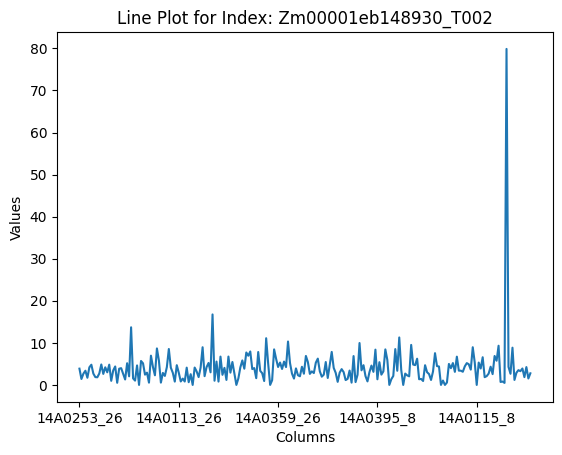

In [45]:
import matplotlib.pyplot as plt

# Plot the line plot
kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb148930_T002'].plot(kind='line')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title(f'Line Plot for Index: Zm00001eb148930_T002')

# Show the plot
plt.show()

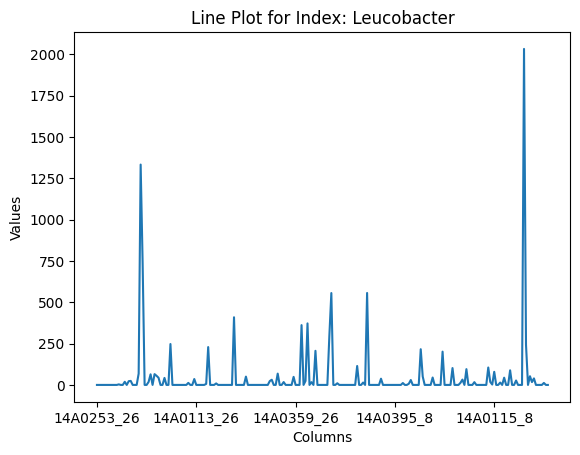

In [46]:
import matplotlib.pyplot as plt

# Plot the line plot
genus_table_merged_d_n_night_cpm_filtered_cv_filtered.loc['Leucobacter'].plot(kind='line')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title(f'Line Plot for Index: Leucobacter')

# Show the plot
plt.show()

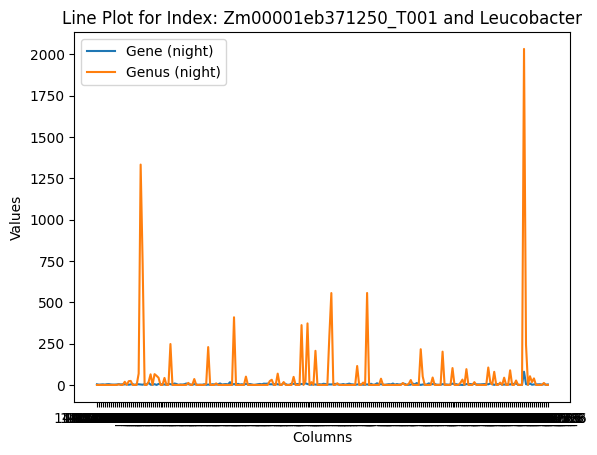

In [48]:
import matplotlib.pyplot as plt

# Plot the line plots for gene and genus
plt.plot(kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb148930_T002'],
         label='Gene (night)')
plt.plot(genus_table_merged_d_n_night_cpm_filtered_cv_filtered.loc['Leucobacter'],
         label='Genus (night)')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Line Plot for Index: Zm00001eb371250_T001 and Leucobacter')

# Add legend
plt.legend()

# Show the plot
plt.show()

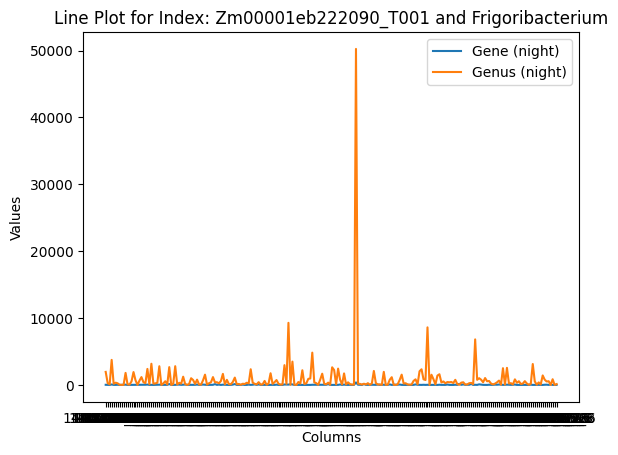

In [50]:
import matplotlib.pyplot as plt

# Plot the line plots for gene and genus
plt.plot(kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb222090_T001'],
         label='Gene (night)')
plt.plot(genus_table_merged_d_n_night_cpm_filtered_cv_filtered.loc['Frigoribacterium'],
         label='Genus (night)')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Line Plot for Index: Zm00001eb222090_T001 and Frigoribacterium')

# Add legend
plt.legend()

# Show the plot
plt.show()

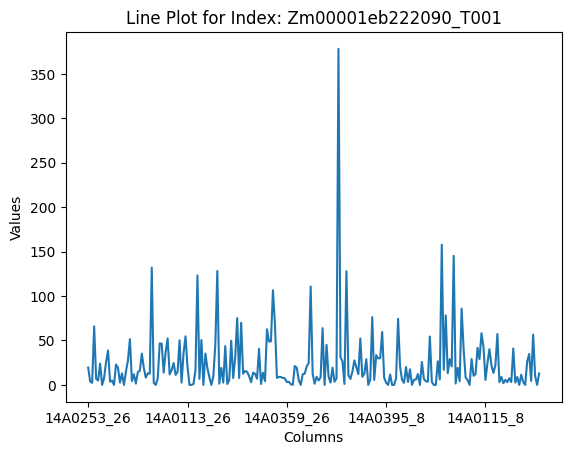

In [54]:
import matplotlib.pyplot as plt

# Plot the line plot
kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb222090_T001'].plot(kind='line')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title(f'Line Plot for Index: Zm00001eb222090_T001')

# Show the plot
plt.show()

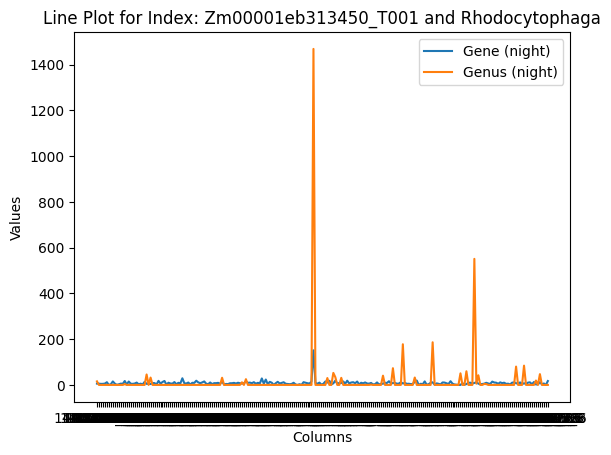

In [53]:
import matplotlib.pyplot as plt

# Plot the line plots for gene and genus
plt.plot(kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb313450_T001'],
         label='Gene (night)')
plt.plot(genus_table_merged_d_n_night_cpm_filtered_cv_filtered.loc['Rhodocytophaga'],
         label='Genus (night)')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Line Plot for Index: Zm00001eb313450_T001 and Rhodocytophaga')

# Add legend
plt.legend()

# Show the plot
plt.show()

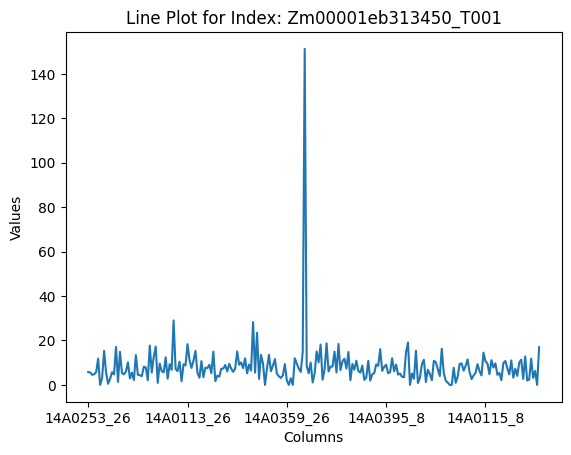

In [55]:
import matplotlib.pyplot as plt

# Plot the line plot
kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb313450_T001'].plot(kind='line')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title(f'Line Plot for Index: Zm00001eb313450_T001')

# Show the plot
plt.show()

In [47]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(genus_table_merged_d_n_night_cpm_filtered_cv_filtered.loc['Leucobacter'],
                                kremling_expression_v5_night_tpm_filtered_cv_filtered.loc['Zm00001eb148930_T002'])

# Print the correlation coefficient and p-value
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Correlation coefficient: 0.6323188368822068
P-value: 7.343200340978372e-27


In [29]:
set([k[0] for k in pairs_night_genetpm_genuscpm])

{'Frigoribacterium',
 'Leucobacter',
 'Paenibacillus_J',
 'Rathayibacter',
 'Rhizobium_A',
 'Rhodocytophaga'}

In [31]:
set([k[1] for k in pairs_night_genetpm_genuscpm])

{'Zm00001eb148930_T002',
 'Zm00001eb167720_T001',
 'Zm00001eb222080_T001',
 'Zm00001eb222090_T001',
 'Zm00001eb313450_T001'}

In [27]:
len(set([k[0] for k in pairs_day_genetpm_genuscpm]))

12

In [30]:
set([k[0] for k in pairs_day_genetpm_genuscpm])

{'Azomonas',
 'Curtobacterium',
 'Dyadobacter',
 'Eikenella',
 'Empedobacter',
 'Gemella',
 'Paenibacillus_J',
 'Rhabdothermincola_A',
 'Serinicoccus',
 'Staphylococcus',
 'Terrabacter',
 'Terracoccus'}

In [33]:
len(set([k[1] for k in pairs_day_genetpm_genuscpm]))

60

### Correlations - gene TPM (no asinh) versus Taxon at Family (CPM)

In [34]:
family_table_merged_d_n_day_cpm_filtered_cv_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_day_cpm_filtered_cv_filtered.tsv',
                                                            sep='\t')
family_table_merged_d_n_day_cpm_filtered_cv_filtered.set_index('Family', inplace=True)
family_table_merged_d_n_night_cpm_filtered_cv_filtered = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/family_table_merged_d_n_night_cpm_filtered_cv_filtered.tsv',
                                                            sep='\t')
family_table_merged_d_n_night_cpm_filtered_cv_filtered.set_index('Family', inplace=True)

In [35]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_filtered_cv_filtered, family_table_merged_d_n_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_filtered_cv_filtered, family_table_merged_d_n_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_tpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_tpm_filtered_cv_filtered.shape[0]

pairs_day_genetpm_familycpm = []
pairs_night_genetpm_familycpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genetpm_familycpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genetpm_familycpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [36]:
set([k[0] for k in pairs_night_genetpm_familycpm])

{'172606-1'}

In [38]:
set([k[1] for k in pairs_night_genetpm_familycpm])

{'Zm00001eb313450_T001'}

In [41]:
len(set([k[0] for k in pairs_day_genetpm_familycpm]))

6

In [42]:
set([k[0] for k in pairs_day_genetpm_familycpm])

{'Alteromonadaceae',
 'Amphibacillaceae',
 'Gemellaceae',
 'Lactobacillaceae',
 'Peptostreptococcaceae',
 'Polyangiaceae'}

In [40]:
len(set([k[1] for k in pairs_day_genetpm_familycpm]))

44

## Correlations - gene (no asinh) versus OTU (CPM)

In [17]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


### OTU (CPM) - Gene (CPM)

In [18]:
concat_df_night = pd.concat([kremling_expression_v5_night_cpm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cpm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genecpm_otucpm = []
pairs_night_genecpm_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genecpm_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genecpm_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [19]:
print(len(pairs_day_genecpm_otucpm))
print(len(pairs_night_genecpm_otucpm))

599
110


### OTU (CPM) - Gene (TPM)

In [20]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genetpm_otucpm = []
pairs_night_genetpm_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genetpm_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genetpm_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))


/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [21]:
print(len(pairs_day_genetpm_otucpm))
print(len(pairs_night_genetpm_otucpm))

552
112


### OTU (CPM) - Gene (TMM)

In [22]:
concat_df_night = pd.concat([kremling_expression_v5_night_tmm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tmm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genetmm_otucpm = []
pairs_night_genetmm_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genetmm_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genetmm_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [23]:
print(len(pairs_day_genetmm_otucpm))
print(len(pairs_night_genetmm_otucpm))

620
92


### OTU (CPM) - Gene (RPKM)

In [26]:
concat_df_night = pd.concat([kremling_expression_v5_night_rpkm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_rpkm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_generpkm_otucpm = []
pairs_night_generpkm_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_generpkm_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_generpkm_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [27]:
print(len(pairs_day_generpkm_otucpm))
print(len(pairs_night_generpkm_otucpm))

599
110


### OTU (CPM) - Gene (UQ)

In [28]:
concat_df_night = pd.concat([kremling_expression_v5_night_uq_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_uq_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_geneuq_otucpm = []
pairs_night_geneuq_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_geneuq_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_geneuq_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [29]:
print(len(pairs_day_geneuq_otucpm))
print(len(pairs_night_geneuq_otucpm))

1931
95


### OTU (CPM) - Gene (CTF)

In [30]:
concat_df_night = pd.concat([kremling_expression_v5_night_ctf_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_ctf_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genectf_otucpm = []
pairs_night_genectf_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genectf_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genectf_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [31]:
print(len(pairs_day_genectf_otucpm))
print(len(pairs_night_genectf_otucpm))

1045
170


### OTU (CPM) - Gene (CUF)

In [32]:
concat_df_night = pd.concat([kremling_expression_v5_night_cuf_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cuf_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

# Calculating pvalues and corrected pvalues
from corals.correlation.utils import derive_pvalues, multiple_test_correction

cor_threshold = 0.6
cor_pvalue_threshold = 0.05

n_samples_day = concatenated_transposed_day.shape[0]
n_features_day = concatenated_transposed_day.shape[1]
n_samples_night = concatenated_transposed_night.shape[0]
n_features_night = concatenated_transposed_night.shape[1]

day_pvalues = derive_pvalues(cor_values_day, n_samples_day)
day_pvalues_corrected = multiple_test_correction(day_pvalues, n_features_day, method="bonferroni")
night_pvalues = derive_pvalues(cor_values_night, n_samples_night)
night_pvalues_corrected = multiple_test_correction(night_pvalues, n_features_night, method="bonferroni")

true_positions_day_cor = np.where(cor_values_day > cor_threshold)
true_positions_night_cor = np.where(cor_values_night > cor_threshold)

true_positions_day_pvalue = np.where(day_pvalues_corrected < cor_pvalue_threshold)
true_positions_night_pvalue = np.where(night_pvalues_corrected < cor_pvalue_threshold)

# Filtering correlations based on coef. and corrected pvalues
cor_tuples_day = []
pval_tuples_day = []

for i in range(np.size(true_positions_day_cor, 1)):
    cor_tuples_day.append((true_positions_day_cor[0][i],
    true_positions_day_cor[1][i]))

for i in range(np.size(true_positions_day_pvalue, 1)):
    pval_tuples_day.append((true_positions_day_pvalue[0][i],
    true_positions_day_pvalue[1][i]))

cor_tuples_night = []
pval_tuples_night = []

for i in range(np.size(true_positions_night_cor, 1)):
    cor_tuples_night.append((true_positions_night_cor[0][i],
    true_positions_night_cor[1][i]))

for i in range(np.size(true_positions_night_pvalue, 1)):
    pval_tuples_night.append((true_positions_night_pvalue[0][i],
    true_positions_night_pvalue[1][i]))

cor_tuples_day_set = set(cor_tuples_day)
pval_tuples_day_set = set(pval_tuples_day)
cor_tuples_night_set = set(cor_tuples_night)
pval_tuples_night_set = set(pval_tuples_night)

cor_pval_intersection_day = cor_tuples_day_set.intersection(pval_tuples_day_set)
cor_pval_intersection_night = cor_tuples_night_set.intersection(pval_tuples_night_set)

cor_pval_intersection_day_tuple = ([t[0] for t in list(cor_pval_intersection_day)],
[t[1] for t in list(cor_pval_intersection_day)])
cor_pval_intersection_night_tuple = ([t[0] for t in list(cor_pval_intersection_night)],
[t[1] for t in list(cor_pval_intersection_night)])

shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genecuf_otucpm = []
pairs_night_genecuf_otucpm = []

for i in range(len(cor_pval_intersection_day_tuple[0])):
    if (cor_pval_intersection_day_tuple[1][i] > (shape_row_day - 1)) and (cor_pval_intersection_day_tuple[0][i] < shape_row_day):
        pairs_day_genecuf_otucpm.append((str(cor_values_day.columns[cor_pval_intersection_day_tuple[1][i]]),
              str(cor_values_day.index[cor_pval_intersection_day_tuple[0][i]]),
              cor_values_day.iloc[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]],
              day_pvalues_corrected[cor_pval_intersection_day_tuple[0][i], cor_pval_intersection_day_tuple[1][i]]))

for i in range(len(cor_pval_intersection_night_tuple[0])):
    if (cor_pval_intersection_night_tuple[1][i] > (shape_row_night - 1)) and (cor_pval_intersection_night_tuple[0][i] < shape_row_night):
        pairs_night_genecuf_otucpm.append((str(cor_values_night.columns[cor_pval_intersection_night_tuple[1][i]]),
              str(cor_values_night.index[cor_pval_intersection_night_tuple[0][i]]),
              cor_values_night.iloc[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]],
              night_pvalues_corrected[cor_pval_intersection_night_tuple[0][i], cor_pval_intersection_night_tuple[1][i]]))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/correlation/utils.py:227: RuntimeWarning: divide by zero encountered in divide
  ts = rf * rf * (df / (1 - rf * rf))


In [33]:
print(len(pairs_day_genecuf_otucpm))
print(len(pairs_night_genecuf_otucpm))

928
158


In [34]:
import upsetplot

from upsetplot import from_contents

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

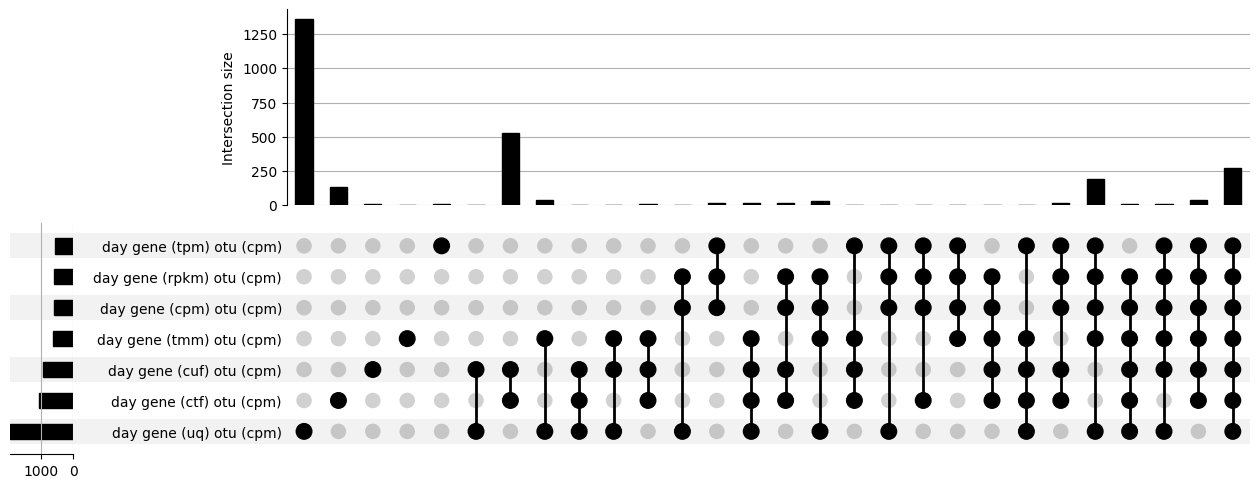

In [41]:
k1 = [(k[0], k[1]) for k in pairs_day_genecpm_otucpm]
k2 = [(k[0], k[1]) for k in pairs_day_genetpm_otucpm]
k3 = [(k[0], k[1]) for k in pairs_day_genetmm_otucpm]
k4 = [(k[0], k[1]) for k in pairs_day_generpkm_otucpm]
k5 = [(k[0], k[1]) for k in pairs_day_geneuq_otucpm]
k6 = [(k[0], k[1]) for k in pairs_day_genectf_otucpm]
k7 = [(k[0], k[1]) for k in pairs_day_genecuf_otucpm]

correlations_day = from_contents(
    {"day gene (cpm) otu (cpm)": k1,
    "day gene (tpm) otu (cpm)": k2,
    "day gene (tmm) otu (cpm)": k3,
    "day gene (rpkm) otu (cpm)": k4,
    "day gene (uq) otu (cpm)": k5,
    "day gene (ctf) otu (cpm)": k6,
    "day gene (cuf) otu (cpm)": k7}
)

otucpm_severalgeneexpmethods_day = set(k1).intersection(set(k2),
                                             set(k3),
                                             set(k4),
                                             set(k5),
                                             set(k6),
                                             set(k7))


from upsetplot import UpSet

ax_dict = UpSet(correlations_day, subset_size="count").plot()

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

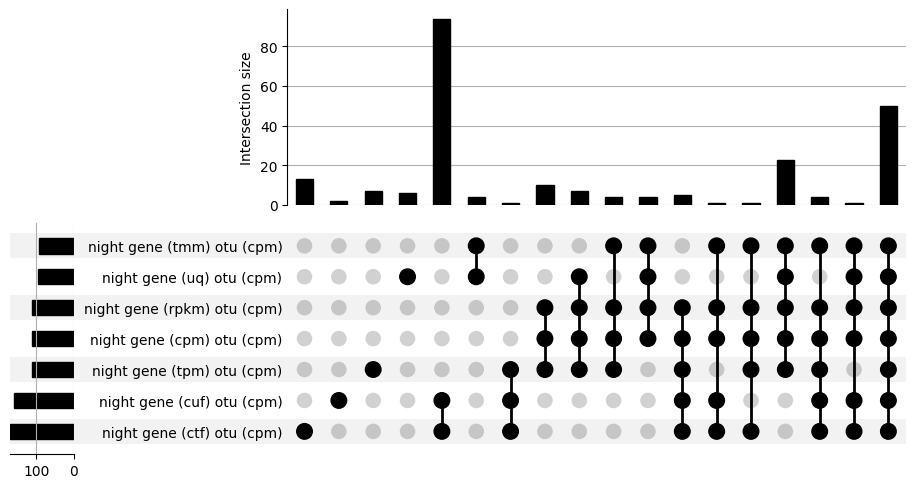

In [42]:
k1 = [(k[0], k[1]) for k in pairs_night_genecpm_otucpm]
k2 = [(k[0], k[1]) for k in pairs_night_genetpm_otucpm]
k3 = [(k[0], k[1]) for k in pairs_night_genetmm_otucpm]
k4 = [(k[0], k[1]) for k in pairs_night_generpkm_otucpm]
k5 = [(k[0], k[1]) for k in pairs_night_geneuq_otucpm]
k6 = [(k[0], k[1]) for k in pairs_night_genectf_otucpm]
k7 = [(k[0], k[1]) for k in pairs_night_genecuf_otucpm]

correlations_night = from_contents(
    {"night gene (cpm) otu (cpm)": k1,
    "night gene (tpm) otu (cpm)": k2,
    "night gene (tmm) otu (cpm)": k3,
    "night gene (rpkm) otu (cpm)": k4,
    "night gene (uq) otu (cpm)": k5,
    "night gene (ctf) otu (cpm)": k6,
    "night gene (cuf) otu (cpm)": k7}
)

otucpm_severalgeneexpmethods_night = set(k1).intersection(set(k2),
                                             set(k3),
                                             set(k4),
                                             set(k5),
                                             set(k6),
                                             set(k7))

from upsetplot import UpSet

ax_dict = UpSet(correlations_night, subset_size="count").plot()

## Summarizing results of different normalization methods (not transfomed) versus OTU (CPM)

In [43]:
union_day_night = set(otucpm_severalgeneexpmethods_night).union(otucpm_severalgeneexpmethods_day)
intersection_day_night = set(otucpm_severalgeneexpmethods_night).intersection(otucpm_severalgeneexpmethods_day)

In [44]:
unique_day = set(otucpm_severalgeneexpmethods_night).difference(otucpm_severalgeneexpmethods_day)
unique_night = set(otucpm_severalgeneexpmethods_day).difference(otucpm_severalgeneexpmethods_night)

In [45]:
print(len(union_day_night),
      len(intersection_day_night),
      len(unique_day),
      len(unique_night))

309 11 39 259


In [48]:
intersection_day_night

{('675357', 'Zm00001eb331240_T001'),
 ('New.ReferenceOTU2896', 'Zm00001eb419390_T001'),
 ('New.ReferenceOTU3089', 'Zm00001eb150050_T001'),
 ('New.ReferenceOTU3089', 'Zm00001eb419390_T001'),
 ('New.ReferenceOTU3269', 'Zm00001eb014000_T001'),
 ('New.ReferenceOTU3269', 'Zm00001eb150050_T001'),
 ('New.ReferenceOTU3269', 'Zm00001eb252850_T001'),
 ('New.ReferenceOTU3269', 'Zm00001eb288360_T001'),
 ('New.ReferenceOTU3269', 'Zm00001eb419390_T001'),
 ('New.ReferenceOTU702', 'Zm00001eb419390_T001'),
 ('New.ReferenceOTU7856', 'Zm00001eb419390_T001')}

In [46]:
set([corpair[0] for corpair in intersection_day_night])

{'675357',
 'New.ReferenceOTU2896',
 'New.ReferenceOTU3089',
 'New.ReferenceOTU3269',
 'New.ReferenceOTU702',
 'New.ReferenceOTU7856'}

In [47]:
list(set([corpair[1] for corpair in intersection_day_night]))

['Zm00001eb288360_T001',
 'Zm00001eb252850_T001',
 'Zm00001eb331240_T001',
 'Zm00001eb419390_T001',
 'Zm00001eb150050_T001',
 'Zm00001eb014000_T001']

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

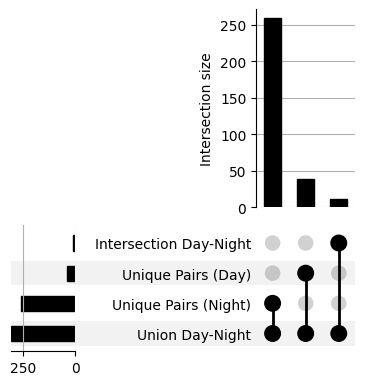

In [52]:
correlations_day_night = from_contents(
    {"Union Day-Night": union_day_night,
    "Intersection Day-Night": intersection_day_night,
    "Unique Pairs (Day)": unique_day,
    "Unique Pairs (Night)": unique_night})

from upsetplot import UpSet

ax_dict = UpSet(correlations_day_night, subset_size="count").plot()

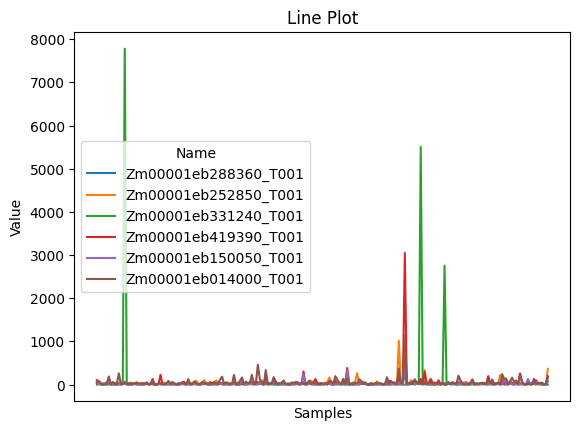

In [49]:
import pandas as pd

import matplotlib.pyplot as plt

# Plot the selected row
kremling_expression_v5_night_tpm.loc[list(set([corpair[1] for corpair in intersection_day_night]))].T.plot(kind='line')

# Set plot title and labels
plt.title('Line Plot')
plt.ylabel('Value')
plt.xlabel('Samples')
plt.xticks([])

# Display the plot
plt.show()

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

# Plot the selected row
kremling_expression_v5_day_tpm.loc[list(set([corpair[1] for corpair in intersection_day_night]))].T.plot(kind='line')

# Set plot title and labels
plt.title('Line Plot')
plt.ylabel('Value')
plt.xlabel('Samples')
plt.xticks([])

# Display the plot
plt.show()

In [ ]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

#Computing zscores
kremling_expression_v5_night_tpm.loc[list(set([corpair[1] for corpair in intersection_day_night]))].apply(zscore, axis=1).T.plot(kind='line')

# Set plot title and labels
plt.title('Line Plot')
plt.ylabel('Value')
plt.xlabel('Samples')
plt.xticks([])

# Display the plot
plt.show()

In [ ]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

#Computing zscores
kremling_expression_v5_day_tpm.loc[list(set([corpair[1] for corpair in intersection_day_night]))].apply(zscore, axis=1).T.plot(kind='line')

# Set plot title and labels
plt.title('Line Plot')
plt.ylabel('Value')
plt.xlabel('Samples')
plt.xticks([])

# Display the plot
plt.show()

### Getting maize annotation and OTU taxonomy

#### Maize annotation

Annotation file was downloaded from Phytozome for the maize v5 genome.

In [56]:
import pandas as pd

zmays_v5_annotation = pd.read_csv("/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/annotation/Phytozome/PhytozomeV13/Zmays/Zm-B73-REFERENCE-NAM-5.0.55/annotation/Zmays_833_Zm-B73-REFERENCE-NAM-5.0.55.annotation_info.txt",
            sep='\t')
zmays_v5_annotation.set_index('transcriptName', inplace=True)
zmays_v5_annotation.head()

,#pacId,locusName,peptideName,Pfam,Panther,ec,KOG,KO,GO,Best-hit-arabi-name,Best-hit-arabi-defline,Best-hit-clamy-name,Best-hit-clamy-defline,Best-hit-rice-name,Best-hit-rice-defline
transcriptName,,,,,,,,,,,,,,,
Zm00001eb000010_T001,PAC:61176664,Zm00001eb000010,Zm00001eb000010_P001,PF02536,PTHR13068 PTHR13068:SF3,NaN,KOG1267,K15032,GO:0003690 GO:0005739 GO:0006355,AT1G78930,Mitochondrial transcription termination factor...,Cre12.g560750,(1 of 8) PTHR13068 - CGI-12 PROTEIN-RELATED,LOC_Os09g38720,"mTERF domain containing protein, expressed"
Zm00001eb000020_T001,PAC:61179637,Zm00001eb000020,Zm00001eb000020_P001,PF01466 PF03931,PTHR11165,NaN,KOG1724,NaN,GO:0006511,NaN,NaN,NaN,NaN,LOC_Os04g52650,expressed protein
Zm00001eb000020_T002,PAC:61179638,Zm00001eb000020,Zm00001eb000020_P002,PF01466 PF03931,PTHR11165,NaN,KOG1724,NaN,GO:0006511,NaN,NaN,NaN,NaN,LOC_Os04g52650,expressed protein
Zm00001eb000020_T003,PAC:61179640,Zm00001eb000020,Zm00001eb000020_P003,PF01466 PF03931,PTHR11165,NaN,KOG1724,NaN,GO:0006511,NaN,NaN,NaN,NaN,LOC_Os04g52650,expressed protein
Zm00001eb000020_T004,PAC:61179639,Zm00001eb000020,Zm00001eb000020_P004,NaN,NaN,EC:1.14.99.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOC_Os04g52650,expressed protein


In [70]:
import itertools

set(list(itertools.chain.from_iterable([gene_gos.split(' ') for gene_gos in zmays_v5_annotation.loc[list(set([corpair[1] for corpair in intersection_day_night]))]['GO'] if not pd.isnull(gene_gos)])))

{'GO:0003677',
 'GO:0004519',
 'GO:0004867',
 'GO:0005576',
 'GO:0006298',
 'GO:0006355',
 'GO:0006952',
 'GO:0009607'}

In [71]:
set(list(itertools.chain.from_iterable([gene_gos.split(' ') for gene_gos in zmays_v5_annotation.loc[list(set([corpair[1] for corpair in unique_day]))]['GO'] if not pd.isnull(gene_gos)])))

{'GO:0000786',
 'GO:0003677',
 'GO:0004519',
 'GO:0004867',
 'GO:0005576',
 'GO:0005622',
 'GO:0005634',
 'GO:0006006',
 'GO:0006298',
 'GO:0006355',
 'GO:0006486',
 'GO:0006810',
 'GO:0008373',
 'GO:0016620',
 'GO:0016791',
 'GO:0042742',
 'GO:0046982',
 'GO:0050661',
 'GO:0050832',
 'GO:0051225',
 'GO:0051287',
 'GO:0055085',
 'GO:0055114',
 'GO:0070652'}

In [75]:
set(list(itertools.chain.from_iterable([gene_gos.split(' ') for gene_gos in zmays_v5_annotation.loc[list(set([corpair[1] for corpair in unique_night]))]['GO'] if not pd.isnull(gene_gos)])))

{'GO:0000162',
 'GO:0003677',
 'GO:0003700',
 'GO:0003723',
 'GO:0003735',
 'GO:0003824',
 'GO:0003854',
 'GO:0003951',
 'GO:0004001',
 'GO:0004049',
 'GO:0004190',
 'GO:0004332',
 'GO:0004357',
 'GO:0004601',
 'GO:0004672',
 'GO:0004713',
 'GO:0004722',
 'GO:0004857',
 'GO:0004867',
 'GO:0004869',
 'GO:0005488',
 'GO:0005509',
 'GO:0005515',
 'GO:0005524',
 'GO:0005525',
 'GO:0005622',
 'GO:0005737',
 'GO:0005739',
 'GO:0005840',
 'GO:0005875',
 'GO:0006090',
 'GO:0006096',
 'GO:0006099',
 'GO:0006166',
 'GO:0006355',
 'GO:0006412',
 'GO:0006415',
 'GO:0006468',
 'GO:0006470',
 'GO:0006508',
 'GO:0006537',
 'GO:0006694',
 'GO:0006741',
 'GO:0006750',
 'GO:0006779',
 'GO:0006801',
 'GO:0006950',
 'GO:0006952',
 'GO:0006979',
 'GO:0007017',
 'GO:0007264',
 'GO:0007275',
 'GO:0008152',
 'GO:0008168',
 'GO:0008234',
 'GO:0008270',
 'GO:0008519',
 'GO:0008964',
 'GO:0009058',
 'GO:0009507',
 'GO:0009607',
 'GO:0009611',
 'GO:0010167',
 'GO:0015031',
 'GO:0015696',
 'GO:0015706',
 'GO:00159

#### OTU taxonomy

Taxonomy assigment was carried out using qiime2 and GTDB version 214.

For some reason, the assignment is possible only until the genus level (likely due to a bug, because the file apparently shows species level but breaking the field after the whitespace)

In [76]:
import pandas as pd

otu_assignment_gtdb2014 = pd.read_csv("/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Wallace_et_al_2018_2/Classification_GTDB/gtdb-214_rep_set_taxonomy/taxonomy.tsv",
                                      sep='\t')
otu_assignment_gtdb2014.set_index('Feature ID', inplace=True)
otu_assignment_gtdb2014.head()

,Taxon,Confidence
Feature ID,,
10001,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,0.999554
1000148,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,0.999977
1000161,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,0.852679
1000188,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,0.996888
1000269,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,0.996307


<Axes: xlabel='Taxon'>

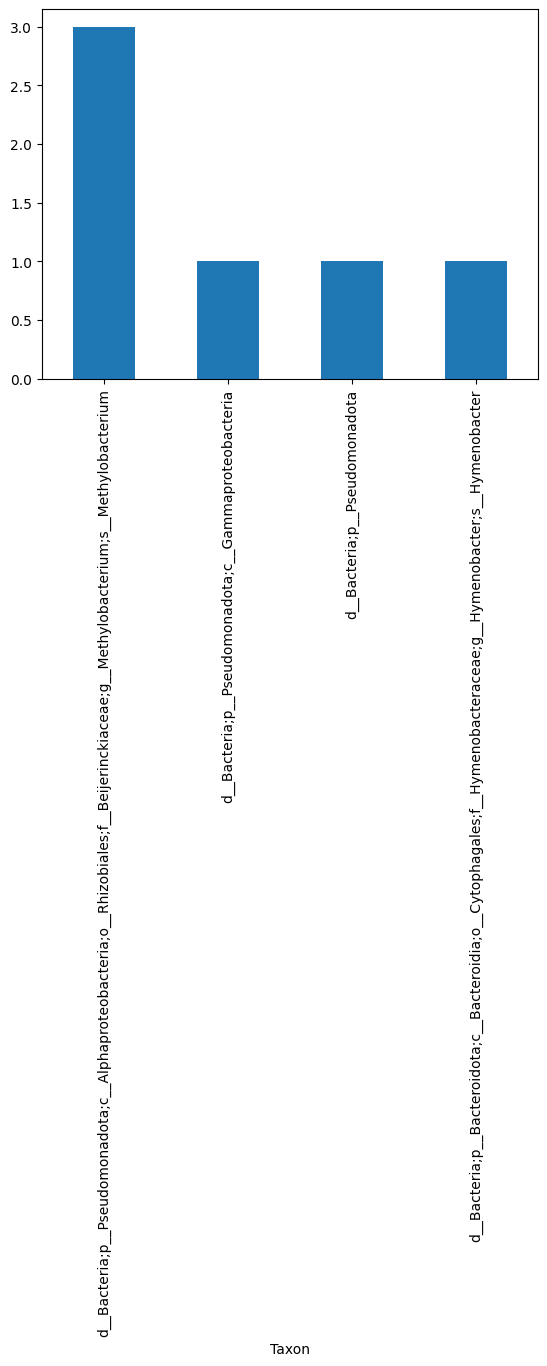

In [93]:
pd.set_option('max_colwidth', 1000)
otu_assignment_gtdb2014.loc[list(set([corpair[0] for corpair in intersection_day_night]))]['Taxon'].value_counts().plot(kind='bar', fontsize=10, rot=90)

In [78]:
# This is apparently the default width; return to it
pd.set_option('max_colwidth', 50)

## Correlations - gene (asinh) versus OTU (CPM - asinh)

Initial tests with gene expression transformed using the asinh function did not return anything if correlations were made with untransformed OTU values (CPM without asinh). Therefore, I tested correlations after transforming all data equally (OTUs and Gene expressions were transformed)

In [ ]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

### OTU (CPM) - Gene (CPM) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_cpm_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cpm_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_cpm_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_cpm_asinh.shape[0]

pairs_day_genecpmasinh_otucpm = []
pairs_night_genecpmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecpmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecpmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genecpmasinh_otucpm))
print(len(pairs_night_genecpmasinh_otucpm))

### OTU (CPM) - Gene (TPM) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_tpm_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_tpm_asinh.shape[0]

pairs_day_genetpmasinh_otucpm = []
pairs_night_genetpmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetpmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetpmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genetpmasinh_otucpm))
print(len(pairs_night_genetpmasinh_otucpm))

### OTU (CPM) - Gene (RPKM) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_rpkm_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_rpkm_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_rpkm_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_rpkm_asinh.shape[0]

pairs_day_generpkmasinh_otucpm = []
pairs_night_generpkmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_generpkmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_generpkmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_generpkmasinh_otucpm))
print(len(pairs_night_generpkmasinh_otucpm))

### OTU (CPM) - Gene (TMM) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_tmm_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tmm_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_tmm_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_tmm_asinh.shape[0]

pairs_day_genetmmasinh_otucpm = []
pairs_night_genetmmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetmmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetmmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genetmmasinh_otucpm))
print(len(pairs_night_genetmmasinh_otucpm))

### OTU (CPM) - Gene (UQ) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_uq_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_uq_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_uq_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_uq_asinh.shape[0]

pairs_day_geneuqasinh_otucpm = []
pairs_night_geneuqasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_geneuqasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_geneuqasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_geneuqasinh_otucpm))
print(len(pairs_night_geneuqasinh_otucpm))

### OTU (CPM) - Gene (CTF) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_ctf_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_ctf_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_ctf_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_ctf_asinh.shape[0]

pairs_day_genectfasinh_otucpm = []
pairs_night_genectfasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genectfasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genectfasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genectfasinh_otucpm))
print(len(pairs_night_genectfasinh_otucpm))

### OTU (CPM) - Gene (CUF) - ASINH

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_cuf_asinh, otu_table_merged_night_cpm_asinh], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cuf_asinh, otu_table_merged_day_cpm_asinh], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_cuf_asinh.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_cuf_asinh.shape[0]

pairs_day_genecufasinh_otucpm = []
pairs_night_genecufasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecufasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecufasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genecufasinh_otucpm))
print(len(pairs_night_genecufasinh_otucpm))

In [ ]:
import upsetplot

from upsetplot import from_contents

In [ ]:
correlations_asinh_night = from_contents(
    {"night gene (cpm) otu (cpm)": pairs_night_genecpmasinh_otucpm,
    "night gene (tpm) otu (cpm)": pairs_night_genetpmasinh_otucpm,
    "night gene (tmm) otu (cpm)": pairs_night_genetmmasinh_otucpm,
    "night gene (rpkm) otu (cpm)": pairs_night_generpkmasinh_otucpm,
    "night gene (uq) otu (cpm)": pairs_night_geneuqasinh_otucpm,
    "night gene (ctf) otu (cpm)": pairs_night_genectfasinh_otucpm,
    "night gene (cuf) otu (cpm)": pairs_night_genecufasinh_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_night, subset_size="count").plot()

In [ ]:
correlations_asinh_day = from_contents(
    {"day gene (cpm) otu (cpm)": pairs_day_genecpmasinh_otucpm,
    "day gene (tpm) otu (cpm)": pairs_day_genetpmasinh_otucpm,
    "day gene (tmm) otu (cpm)": pairs_day_genetmmasinh_otucpm,
    "day gene (rpkm) otu (cpm)": pairs_day_generpkmasinh_otucpm,
    "day gene (uq) otu (cpm)": pairs_day_geneuqasinh_otucpm,
    "day gene (ctf) otu (cpm)": pairs_day_genectfasinh_otucpm,
    "day gene (cuf) otu (cpm)": pairs_day_genecufasinh_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_day, subset_size="count").plot()

In [ ]:
correlations_asinh_notasinh_day = from_contents(
    {"day gene (cpm) otu (cpm) (ASINH)": pairs_day_genecpmasinh_otucpm,
    "day gene (tpm) otu (cpm) (ASINH)": pairs_day_genetpmasinh_otucpm,
    "day gene (tmm) otu (cpm) (ASINH)": pairs_day_genetmmasinh_otucpm,
    "day gene (rpkm) otu (cpm) (ASINH)": pairs_day_generpkmasinh_otucpm,
    "day gene (uq) otu (cpm) (ASINH)": pairs_day_geneuqasinh_otucpm,
    "day gene (ctf) otu (cpm) (ASINH)": pairs_day_genectfasinh_otucpm,
    "day gene (cuf) otu (cpm) (ASINH)": pairs_day_genecufasinh_otucpm,
    "day gene (cpm) otu (cpm)": pairs_day_genecpm_otucpm,
    "day gene (tpm) otu (cpm)": pairs_day_genetpm_otucpm,
    "day gene (tmm) otu (cpm)": pairs_day_genetmm_otucpm,
    "day gene (rpkm) otu (cpm)": pairs_day_generpkm_otucpm,
    "day gene (uq) otu (cpm)": pairs_day_geneuq_otucpm,
    "day gene (ctf) otu (cpm)": pairs_day_genectf_otucpm,
    "day gene (cuf) otu (cpm)": pairs_day_genecuf_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_notasinh_day, subset_size="count").plot()

In [ ]:
correlations_asinh_notasinh_night = from_contents(
    {"day gene (cpm) otu (cpm) (ASINH)": pairs_night_genecpmasinh_otucpm,
    "day gene (tpm) otu (cpm) (ASINH)": pairs_night_genetpmasinh_otucpm,
    "day gene (tmm) otu (cpm) (ASINH)": pairs_night_genetmmasinh_otucpm,
    "day gene (rpkm) otu (cpm) (ASINH)": pairs_night_generpkmasinh_otucpm,
    "day gene (uq) otu (cpm) (ASINH)": pairs_night_geneuqasinh_otucpm,
    "day gene (ctf) otu (cpm) (ASINH)": pairs_night_genectfasinh_otucpm,
    "day gene (cuf) otu (cpm) (ASINH)": pairs_night_genecufasinh_otucpm,
    "day gene (cpm) otu (cpm)": pairs_night_genecpm_otucpm,
    "day gene (tpm) otu (cpm)": pairs_night_genetpm_otucpm,
    "day gene (tmm) otu (cpm)": pairs_night_genetmm_otucpm,
    "day gene (rpkm) otu (cpm)": pairs_night_generpkm_otucpm,
    "day gene (uq) otu (cpm)": pairs_night_geneuq_otucpm,
    "day gene (ctf) otu (cpm)": pairs_night_genectf_otucpm,
    "day gene (cuf) otu (cpm)": pairs_night_genecuf_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_notasinh_day, subset_size="count").plot()

## Correlations - gene (VST) versus OTU (CPM - VST)

Testing correlations after transforming all data equally (OTUs and Gene expressions were transformed using DESeq2 VST function).

## Correlations - gene (no asinh) versus OTU (relative abundance)

Testing correlations of OTUs (relative abundances after filtering) and Gene expressions (all normalizations, after filtering).

In [ ]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

### OTU (relative abundances) - Gene (CPM)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_cpm_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cpm_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genecpm_oturelabund = []
pairs_night_genecpm_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecpm_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecpm_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genecpm_oturelabund))
print(len(pairs_night_genecpm_oturelabund))

### OTU (relative abundances) - Gene (RPKM)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_rpkm_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_rpkm_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_rpkm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_rpkm_filtered_cv_filtered.shape[0]

pairs_day_generpkm_oturelabund = []
pairs_night_generpkm_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_generpkm_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_generpkm_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_generpkm_oturelabund))
print(len(pairs_night_generpkm_oturelabund))

### OTU (relative abundances) - Gene (TPM)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_tpm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_tpm_filtered_cv_filtered.shape[0]

pairs_day_genetpm_oturelabund = []
pairs_night_genetpm_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetpm_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetpm_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genetpm_oturelabund))
print(len(pairs_night_genetpm_oturelabund))

### OTU (relative abundances) - Gene (TMM)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_tmm_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tmm_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_tmm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_tmm_filtered_cv_filtered.shape[0]

pairs_day_genetmm_oturelabund = []
pairs_night_genetmm_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetmm_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetmm_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genetmm_oturelabund))
print(len(pairs_night_genetmm_oturelabund))

### OTU (relative abundances) - Gene (UQ)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_uq_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_uq_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_uq_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_uq_filtered_cv_filtered.shape[0]

pairs_day_geneuq_oturelabund = []
pairs_night_geneuq_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_geneuq_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_geneuq_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_geneuq_oturelabund))
print(len(pairs_night_geneuq_oturelabund))

### OTU (relative abundances) - Gene (CTF)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_ctf_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_ctf_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_ctf_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_ctf_filtered_cv_filtered.shape[0]

pairs_day_genectf_oturelabund = []
pairs_night_genectf_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genectf_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genectf_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genectf_oturelabund))
print(len(pairs_night_genectf_oturelabund))

### OTU (relative abundances) - Gene (CUF)

In [ ]:
concat_df_night = pd.concat([kremling_expression_v5_night_cuf_filtered_cv_filtered, otu_table_merged_night_relative_abund_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cuf_filtered_cv_filtered, otu_table_merged_day_relative_abund_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_cuf_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_cuf_filtered_cv_filtered.shape[0]

pairs_day_genecuf_oturelabund = []
pairs_night_genecuf_oturelabund = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecuf_oturelabund.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecuf_oturelabund.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [ ]:
print(len(pairs_day_genecuf_oturelabund))
print(len(pairs_night_genecuf_oturelabund))